In [1]:
%load_ext autoreload
#%load_ext nb_black
%load_ext autotime
%autoreload 2


from matplotlib import pyplot as plt
import random
import numpy as np
import pandas as pd
import warnings
import logging
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.dpi"] = 200

random.seed(42)
np.random.seed(42)

logging.basicConfig(level=logging.INFO)

time: 996 ms (started: 2024-05-31 15:20:14 -07:00)


In [68]:
df = pd.read_csv("raw_pivoted.csv.gz", compression="gzip", index_col=0)
df

,degraded,failed,success
timestamp,,,
2024-03-17 23:14,NaN,NaN,1.0
2024-03-17 23:55,NaN,NaN,1.0
2024-03-17 23:57,NaN,NaN,1.0
2024-03-17 23:58,NaN,NaN,3.0
2024-03-17 23:59,1.0,NaN,58.0
...,...,...,...
2024-03-30 23:54,4.0,NaN,48.0
2024-03-30 23:55,2.0,NaN,44.0
2024-03-30 23:56,NaN,NaN,32.0


time: 12.6 ms (started: 2024-05-31 15:58:31 -07:00)


In [69]:
df = df.fillna(0)
# df["degraded"] = df[["failed"]]
# df.plot(subplots=True)

time: 880 µs (started: 2024-05-31 15:58:31 -07:00)


array([<Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>,
       <Axes: xlabel='timestamp'>], dtype=object)

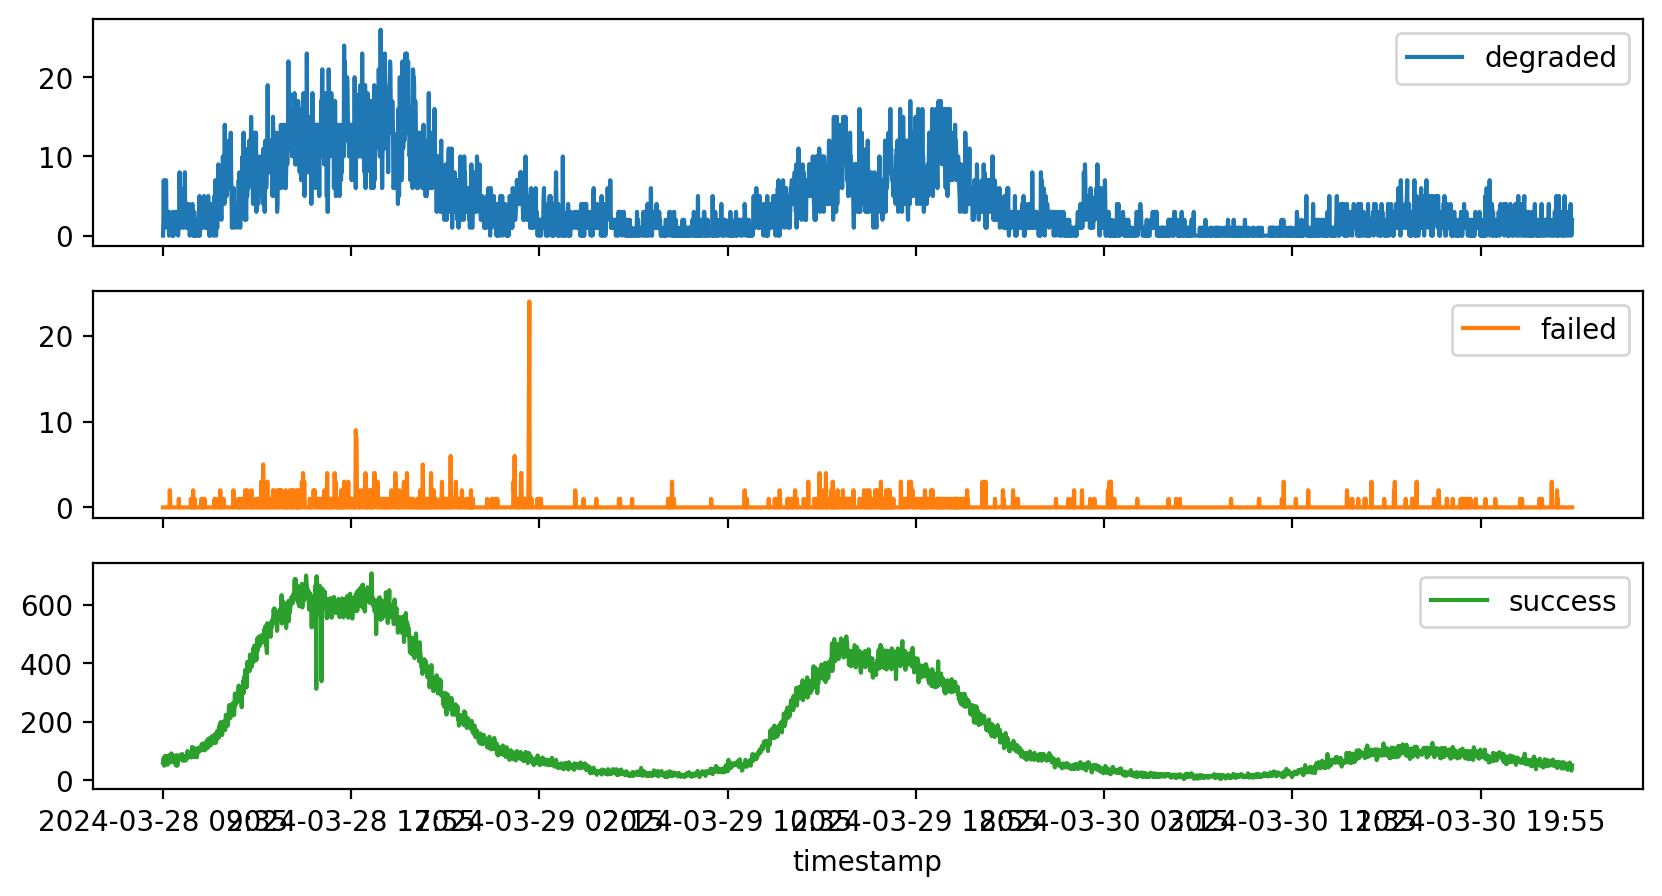

time: 251 ms (started: 2024-05-31 15:58:32 -07:00)


In [70]:
TEST_SPLIT_RATIO = 0.2
df_train, df_test = df.iloc[:-int(TEST_SPLIT_RATIO * (len(df)))], df.iloc[-int(TEST_SPLIT_RATIO * (len(df))):]
df_test.plot(subplots=True)

In [71]:
from numalogic.transforms import LogTransformer

tx = LogTransformer()
x_train = tx.fit_transform(df_train.to_numpy())
x_test = tx.transform(df_test.to_numpy())

time: 1.05 ms (started: 2024-05-31 15:58:34 -07:00)


In [72]:
from torch.utils.data import DataLoader
from numalogic.tools.data import StreamingDataset
from numalogic.models.autoencoder import TimeseriesTrainer
from numalogic.models.autoencoder.variants import VanillaAE

train_ds = StreamingDataset(x_train, seq_len=10)
test_ds = StreamingDataset(x_test, seq_len=10)

INFO:numalogic.tools.data:StreamingDataset initialized with seq_len: 10, stride: 1
INFO:numalogic.tools.data:StreamingDataset initialized with seq_len: 10, stride: 1


time: 2.4 ms (started: 2024-05-31 15:58:35 -07:00)


In [78]:
from numalogic.models.autoencoder.variants.vanilla import MultichannelAE

model_3 = MultichannelAE(seq_len=10, n_channels=3)
trainer = TimeseriesTrainer(max_epochs=50, accelerator="cpu", deterministic=True)
trainer.fit(model_3, train_dataloaders=DataLoader(train_ds, batch_size=512))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:numalogic.tools.callbacks:epoch=1, train_loss=1.7432
INFO:numalogic.tools.callbacks:epoch=5, train_loss=0.6546
INFO:numalogic.tools.callbacks:epoch=10, train_loss=0.3461
INFO:numalogic.tools.callbacks:epoch=15, train_loss=0.3133
INFO:numalogic.tools.callbacks:epoch=20, train_loss=0.2807
INFO:numalogic.tools.callbacks:epoch=25, train_loss=0.2442
INFO:numalogic.tools.callbacks:epoch=30, train_loss=0.2274
INFO:numalogic.tools.callbacks:epoch=35, train_loss=0.2105
INFO:numalogic.tools.callbacks:epoch=40, train_loss=0.1935
INFO:numalogic.tools.callbacks:epoch=45, train_loss=0.1823
INFO:numalogic.tools.callbacks:epoch=50, train_loss=0.1712
INFO:pytorch_lightning.utilit

time: 5.83 s (started: 2024-05-31 15:59:12 -07:00)


[0.04066887 0.00893671 0.08616648] [0.02185199 0.01999152 0.09162112]


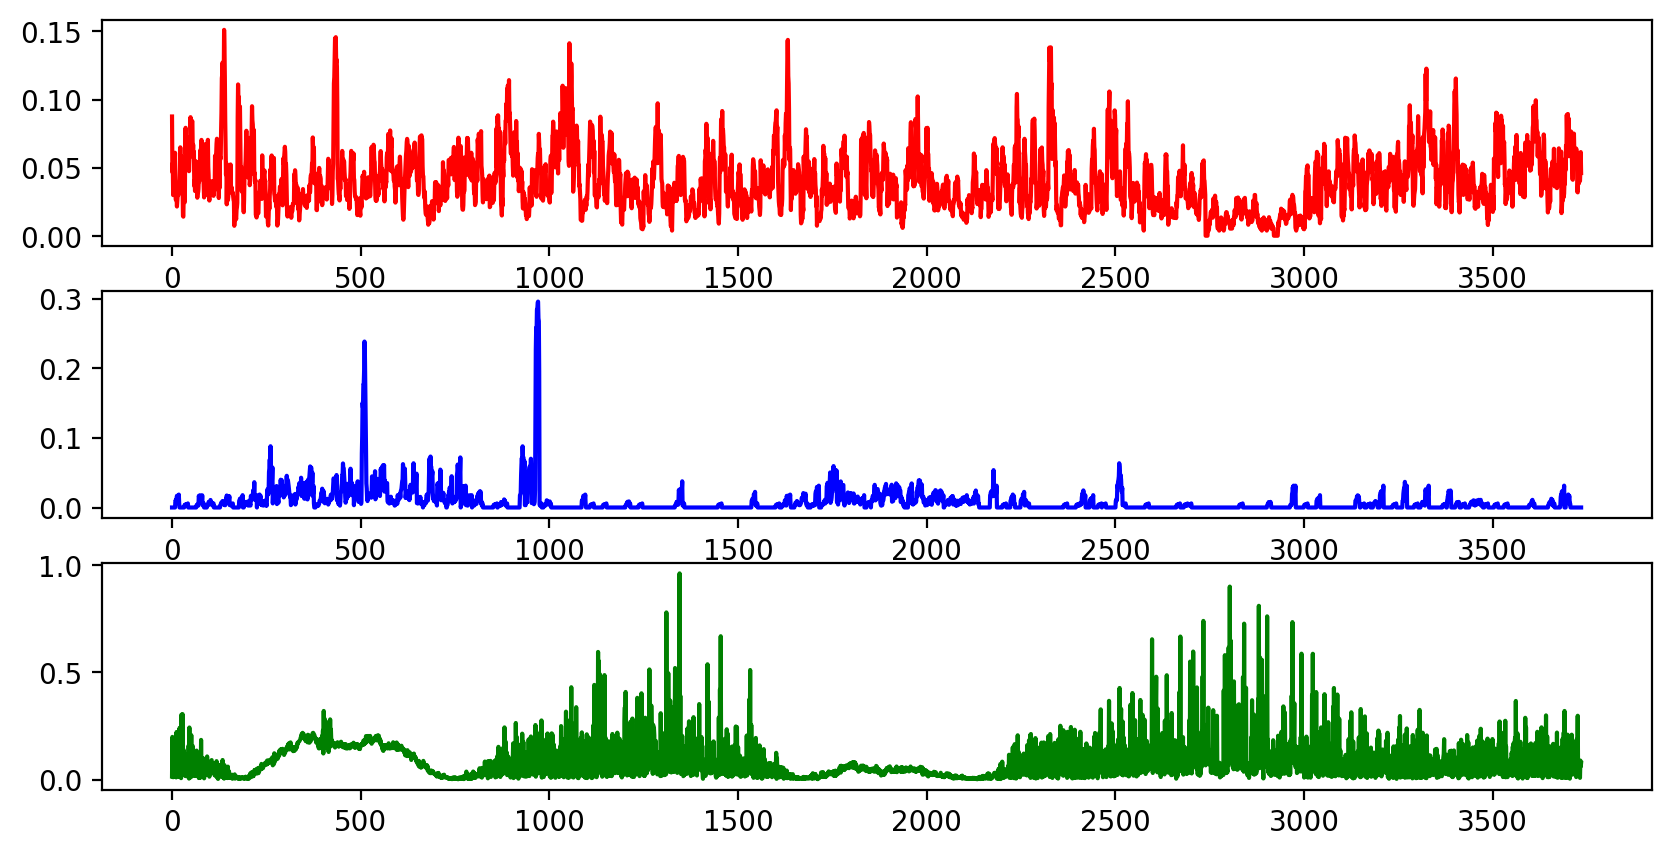

time: 248 ms (started: 2024-05-31 15:59:19 -07:00)


In [79]:
import torch

test_reconerr = trainer.predict(model_3, dataloaders=DataLoader(test_ds, batch_size=512), unbatch=False)
test_reconerr = torch.mean(test_reconerr, dim=1).detach().numpy()
_, ax = plt.subplots(3, 1)
ax[0].plot(test_reconerr[:, 0], color="red")
ax[1].plot(test_reconerr[:, 1], color="blue")
ax[2].plot(test_reconerr[:, 2], color="green")
print(np.mean(test_reconerr, axis=0), np.std(test_reconerr, axis=0))

In [142]:
print(np.mean(test_reconerr, axis=0), np.std(test_reconerr, axis=0))

[0.03049051 0.02789014 0.00610527] [0.0817422  0.08140289 0.0379023 ]
time: 1.15 ms (started: 2024-05-29 16:22:30 -07:00)


# Testing Multichannel Linear Layer

In [20]:
import math
from torch import nn
import torch

l = nn.Linear(5, 3)
print("w", l.weight.shape)
print("b", l.bias.shape)
l(torch.randn(10, 2, 5)).shape

w torch.Size([3, 5])
b torch.Size([3])


torch.Size([10, 2, 3])

time: 5.25 ms (started: 2024-05-31 15:41:04 -07:00)


In [73]:

class MultiChannelLinear(nn.Module):
    def __init__(self, in_features: int, out_features: int, n_channels: int, device=None, dtype=None):
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.n_channels = n_channels
        
        self.weight = nn.Parameter(torch.empty((n_channels, in_features, out_features), **factory_kwargs))
        self.bias = nn.Parameter(torch.empty((n_channels, 1, out_features), **factory_kwargs))
        self.reset_parameters()
        
    def reset_parameters(self) -> None:
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
        bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
        nn.init.uniform_(self.bias, -bound, bound)
    
    def forward(self, x):
        x = torch.swapdims(x, 0, 1)
        output = torch.bmm(x, self.weight) + self.bias
        return torch.swapdims(output, 0, 1)
    
    def extra_repr(self) -> str:
        return f"in_features={self.in_features}, out_features={self.out_features}, n_channels={self.n_channels}"

l = MultiChannelLinear(5, 3, n_channels=2)
l(torch.randn(128, 2, 5)).shape


torch.Size([128, 2, 3])

time: 2.79 ms (started: 2024-05-31 15:58:42 -07:00)


In [74]:
from numalogic.tools.exceptions import LayerSizeMismatchError
from numalogic.models.autoencoder.base import BaseAE
from torch import Tensor
from collections.abc import Sequence


class _VanillaEncoder(nn.Module):
    r"""Encoder module for the VanillaAE.

    Args:
    ----
        seq_len: sequence length / window length
        n_features: num of features
        layersizes: encoder layer size
        dropout_p: the dropout value

    """

    def __init__(
        self,
        seq_len: int,
        n_features: int,
        layersizes: Sequence[int],
        dropout_p: float,
        batchnorm: bool,
    ):
        super().__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.dropout_p = dropout_p
        self.bnorm = batchnorm

        layers = self._construct_layers(layersizes)
        self.encoder = nn.Sequential(*layers)

    def _construct_layers(self, layersizes: Sequence[int]) -> nn.ModuleList:
        r"""Utility function to generate a simple feedforward network layer.

        Args:
        ----
            layersizes: layer size

        Returns
        -------
            A simple feedforward network layer of type nn.ModuleList
        """
        layers = nn.ModuleList()
        start_layersize = self.seq_len

        for lsize in layersizes[:-1]:
            _l = [MultiChannelLinear(start_layersize, lsize, self.n_features)]
            if self.bnorm:
                _l.append(nn.BatchNorm1d(self.n_features))
            layers.extend([*_l, nn.Tanh(), nn.Dropout(p=self.dropout_p)])
            start_layersize = lsize

        _l = [MultiChannelLinear(start_layersize, layersizes[-1], self.n_features)]
        if self.bnorm:
            _l.append(nn.BatchNorm1d(self.n_features))
        layers.extend([*_l, nn.Tanh(), nn.Dropout(p=self.dropout_p)])

        return layers

    def forward(self, x: Tensor) -> Tensor:
        return self.encoder(x)


class _Decoder(nn.Module):
    r"""Decoder module for the autoencoder module.

    Args:
    ----
        seq_len: sequence length / window length
        n_features: num of features
        layersizes: decoder layer size
        dropout_p: the dropout value

    """

    def __init__(
        self,
        seq_len: int,
        n_features: int,
        layersizes: Sequence[int],
        dropout_p: float,
        batchnorm: bool,
    ):
        super().__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.dropout_p = dropout_p
        self.bnorm = batchnorm

        layers = self._construct_layers(layersizes)
        self.decoder = nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        return self.decoder(x)

    def _construct_layers(self, layersizes: Sequence[int]) -> nn.ModuleList:
        r"""Utility function to generate a simple feedforward network layer.

        Args:
        ----
            layersizes: layer size

        Returns
        -------
            A simple feedforward network layer
        """
        layers = nn.ModuleList()

        for idx, _ in enumerate(layersizes[:-1]):
            _l = [MultiChannelLinear(layersizes[idx], layersizes[idx + 1], self.n_features)]
            if self.bnorm:
                _l.append(nn.BatchNorm1d(self.n_features))
            layers.extend([*_l, nn.Tanh(), nn.Dropout(p=self.dropout_p)])

        layers.append(MultiChannelLinear(layersizes[-1], self.seq_len, self.n_features))
        return layers


class VanillaMCAE(BaseAE):
    r"""Vanilla Autoencoder model comprising Fully connected layers only.

    Args:
    ----
        seq_len: sequence length / window length
        n_features: num of features
        encoder_layersizes: encoder layer size (default = Sequence[int] = (16, 8))
        decoder_layersizes: decoder layer size (default = Sequence[int] = (8, 16))
        dropout_p: the dropout value (default=0.25)
        batchnorm: Flag to enable batch normalization (default=False)
        **kwargs: BaseAE kwargs
    """

    def __init__(
        self,
        seq_len: int,
        n_features: int = 1,
        encoder_layersizes: Sequence[int] = (16, 8),
        decoder_layersizes: Sequence[int] = (8, 16),
        dropout_p: float = 0.25,
        batchnorm: bool = False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.seq_len = seq_len
        self.dropout_prob = dropout_p
        self.n_features = n_features

        if encoder_layersizes[-1] != decoder_layersizes[0]:
            raise LayerSizeMismatchError(
                f"Last layersize of encoder: {encoder_layersizes[-1]} "
                f"does not match first layersize of decoder: {decoder_layersizes[0]}"
            )

        self.encoder = _VanillaEncoder(
            seq_len=seq_len,
            n_features=n_features,
            layersizes=encoder_layersizes,
            dropout_p=dropout_p,
            batchnorm=batchnorm,
        )
        self.decoder = _Decoder(
            seq_len=seq_len,
            n_features=n_features,
            layersizes=decoder_layersizes,
            dropout_p=dropout_p,
            batchnorm=batchnorm,
        )

        self.encoder.apply(self.init_weights)
        self.decoder.apply(self.init_weights)

    @staticmethod
    def init_weights(m: nn.Module) -> None:
        """Initialize the parameters in the model."""
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)

    def forward(self, batch: Tensor) -> tuple[Tensor, Tensor]:
        batch = torch.swapdims(batch, 1, 2)
        encoded = self.encoder(batch)
        decoded = self.decoder(encoded)
        return encoded, torch.swapdims(decoded, 1, 2)

    def predict_step(self, batch: Tensor, batch_idx: int, dataloader_idx: int = 0):
        """Returns reconstruction for streaming input."""
        recon = self.reconstruction(batch)
        return self.criterion(batch, recon, reduction="none")

time: 2.49 ms (started: 2024-05-31 15:58:43 -07:00)


In [75]:
model_mc = VanillaMCAE(seq_len=10, n_features=3)
trainer = TimeseriesTrainer(max_epochs=50, accelerator="cpu", deterministic=True)
trainer.fit(model_mc, train_dataloaders=DataLoader(train_ds, batch_size=512))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:numalogic.tools.callbacks:epoch=1, train_loss=1.8940
INFO:numalogic.tools.callbacks:epoch=5, train_loss=0.6273
INFO:numalogic.tools.callbacks:epoch=10, train_loss=0.2995
INFO:numalogic.tools.callbacks:epoch=15, train_loss=0.2711
INFO:numalogic.tools.callbacks:epoch=20, train_loss=0.2680
INFO:numalogic.tools.callbacks:epoch=25, train_loss=0.2641
INFO:numalogic.tools.callbacks:epoch=30, train_loss=0.2579
INFO:numalogic.tools.callbacks:epoch=35, train_loss=0.2386
INFO:numalogic.tools.callbacks:epoch=40, train_loss=0.2224
INFO:numalogic.tools.callbacks:epoch=45, train_loss=0.1897
INFO:numalogic.tools.callbacks:epoch=50, train_loss=0.1557
INFO:pytorch_lightning.utilit

time: 4.13 s (started: 2024-05-31 15:58:44 -07:00)


In [118]:
VanillaAE(seq_len=10)

VanillaAE(
  (encoder): _VanillaEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=10, out_features=16, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.25, inplace=False)
      (3): Linear(in_features=16, out_features=8, bias=True)
      (4): Tanh()
      (5): Dropout(p=0.25, inplace=False)
    )
  )
  (decoder): _Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=8, out_features=16, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.25, inplace=False)
      (3): Linear(in_features=16, out_features=10, bias=True)
    )
  )
)

time: 1.84 ms (started: 2024-05-31 16:24:03 -07:00)


In [117]:
model_mc

VanillaMCAE(
  (encoder): _VanillaEncoder(
    (encoder): Sequential(
      (0): MultiChannelLinear(in_features=10, out_features=16, n_channels=3)
      (1): Tanh()
      (2): Dropout(p=0.25, inplace=False)
      (3): MultiChannelLinear(in_features=16, out_features=8, n_channels=3)
      (4): Tanh()
      (5): Dropout(p=0.25, inplace=False)
    )
  )
  (decoder): _Decoder(
    (decoder): Sequential(
      (0): MultiChannelLinear(in_features=8, out_features=16, n_channels=3)
      (1): Tanh()
      (2): Dropout(p=0.25, inplace=False)
      (3): MultiChannelLinear(in_features=16, out_features=10, n_channels=3)
    )
  )
)

time: 1.37 ms (started: 2024-05-31 16:23:43 -07:00)


In [76]:
test_reconerr = trainer.predict(model_mc, dataloaders=DataLoader(test_ds, batch_size=512), unbatch=False)
test_reconerr = torch.mean(test_reconerr, dim=1).detach().numpy()
test_reconerr.shape

(3735, 3)

time: 15.6 ms (started: 2024-05-31 15:58:49 -07:00)


[0.04802846 0.01477601 0.0897368 ] [0.02549921 0.02871796 0.11533152]


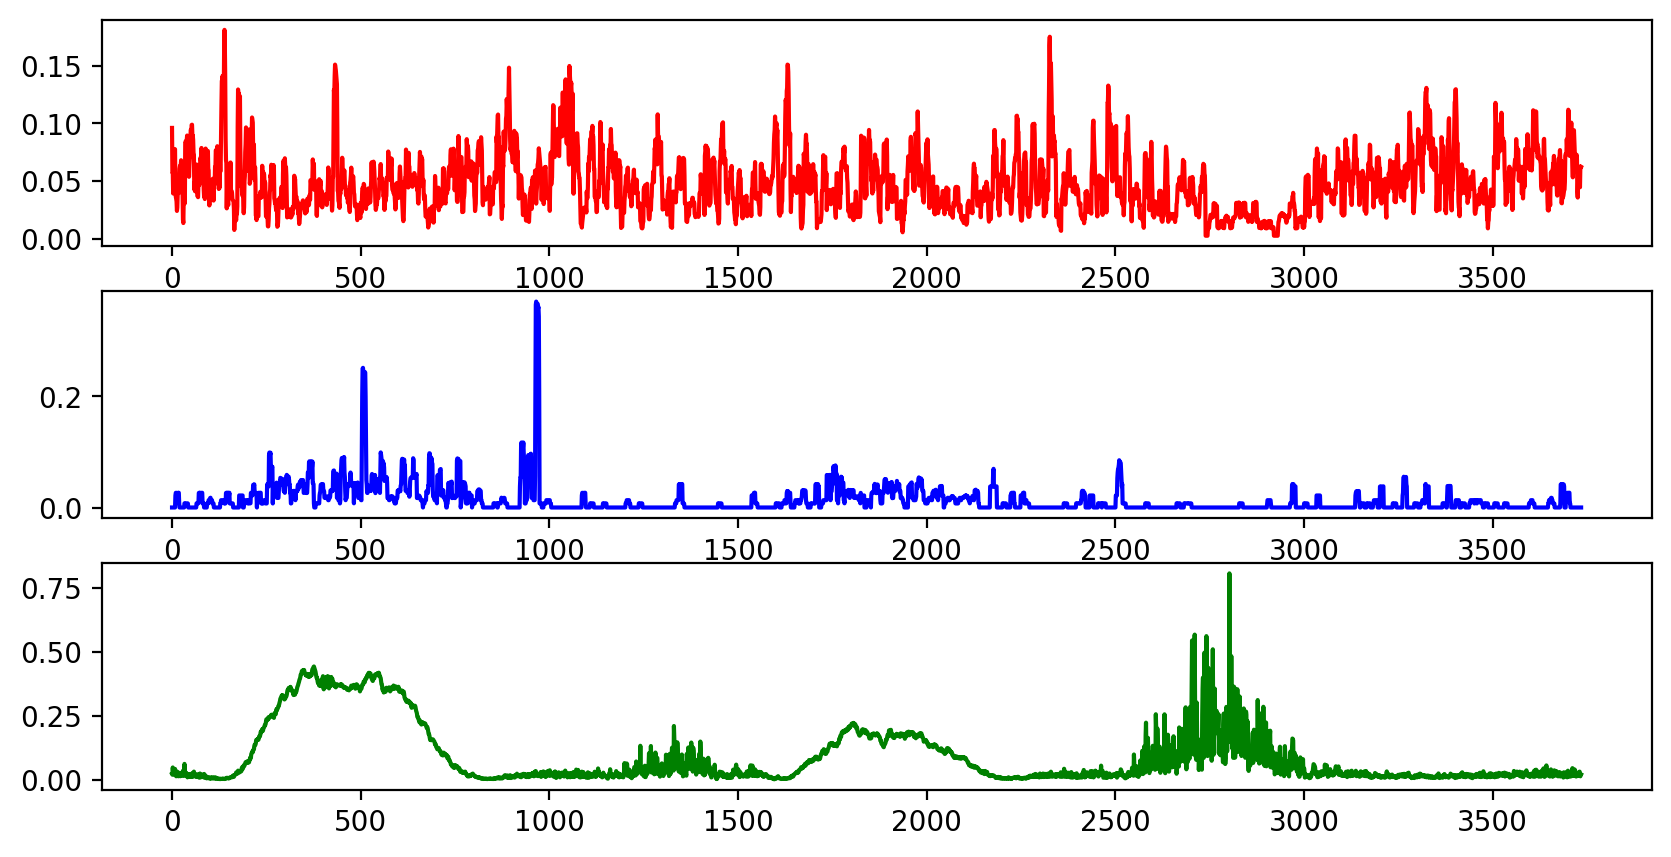

time: 215 ms (started: 2024-05-31 15:58:50 -07:00)


In [77]:
_, ax = plt.subplots(3, 1)
ax[0].plot(test_reconerr[:, 0], color="red")
ax[1].plot(test_reconerr[:, 1], color="blue")
ax[2].plot(test_reconerr[:, 2], color="green")
print(np.mean(test_reconerr, axis=0), np.std(test_reconerr, axis=0))

In [101]:
df_test

,degraded,failed,success
timestamp,,,
2024-03-28 09:35,0.0,0.0,59.0
2024-03-28 09:36,2.0,0.0,70.0
2024-03-28 09:37,7.0,0.0,76.0
2024-03-28 09:38,2.0,0.0,49.0
2024-03-28 09:39,1.0,0.0,63.0
...,...,...,...
2024-03-30 23:54,4.0,0.0,48.0
2024-03-30 23:55,2.0,0.0,44.0
2024-03-30 23:56,0.0,0.0,32.0


time: 5.21 ms (started: 2024-05-31 16:13:30 -07:00)


In [102]:
train_ds_fd = StreamingDataset(x_train[:, [1, 0]], seq_len=10)
test_ds_fd = StreamingDataset(x_test[:, [1, 0]], seq_len=10)
train_ds_fs = StreamingDataset(x_train[:, [1, 2]], seq_len=10)
test_ds_fs = StreamingDataset(x_test[:, [1, 2]], seq_len=10)

INFO:numalogic.tools.data:StreamingDataset initialized with seq_len: 10, stride: 1
INFO:numalogic.tools.data:StreamingDataset initialized with seq_len: 10, stride: 1
INFO:numalogic.tools.data:StreamingDataset initialized with seq_len: 10, stride: 1
INFO:numalogic.tools.data:StreamingDataset initialized with seq_len: 10, stride: 1


time: 1.91 ms (started: 2024-05-31 16:14:00 -07:00)


In [103]:
model_mc_fd = VanillaMCAE(seq_len=10, n_features=2)
trainer = TimeseriesTrainer(max_epochs=50, accelerator="cpu", deterministic=True)
trainer.fit(model_mc_fd, train_dataloaders=DataLoader(train_ds_fd, batch_size=512))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:numalogic.tools.callbacks:epoch=1, train_loss=0.7113
INFO:numalogic.tools.callbacks:epoch=5, train_loss=0.1556
INFO:numalogic.tools.callbacks:epoch=10, train_loss=0.0971
INFO:numalogic.tools.callbacks:epoch=15, train_loss=0.0696
INFO:numalogic.tools.callbacks:epoch=20, train_loss=0.0638
INFO:numalogic.tools.callbacks:epoch=25, train_loss=0.0597
INFO:numalogic.tools.callbacks:epoch=30, train_loss=0.0572
INFO:numalogic.tools.callbacks:epoch=35, train_loss=0.0552
INFO:numalogic.tools.callbacks:epoch=40, train_loss=0.0538
INFO:numalogic.tools.callbacks:epoch=45, train_loss=0.0523
INFO:numalogic.tools.callbacks:epoch=50, train_loss=0.0511
INFO:pytorch_lightning.utilit

time: 4.07 s (started: 2024-05-31 16:14:01 -07:00)


In [104]:
model_3_fd = MultichannelAE(seq_len=10, n_channels=2)
trainer = TimeseriesTrainer(max_epochs=50, accelerator="cpu", deterministic=True)
trainer.fit(model_3_fd, train_dataloaders=DataLoader(train_ds_fd, batch_size=512))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:numalogic.tools.callbacks:epoch=1, train_loss=0.6587
INFO:numalogic.tools.callbacks:epoch=5, train_loss=0.2289
INFO:numalogic.tools.callbacks:epoch=10, train_loss=0.1413
INFO:numalogic.tools.callbacks:epoch=15, train_loss=0.1069
INFO:numalogic.tools.callbacks:epoch=20, train_loss=0.0889
INFO:numalogic.tools.callbacks:epoch=25, train_loss=0.0786
INFO:numalogic.tools.callbacks:epoch=30, train_loss=0.0716
INFO:numalogic.tools.callbacks:epoch=35, train_loss=0.0660
INFO:numalogic.tools.callbacks:epoch=40, train_loss=0.0611
INFO:numalogic.tools.callbacks:epoch=45, train_loss=0.0583
INFO:numalogic.tools.callbacks:epoch=50, train_loss=0.0562
INFO:pytorch_lightning.utilit

time: 4.96 s (started: 2024-05-31 16:14:06 -07:00)


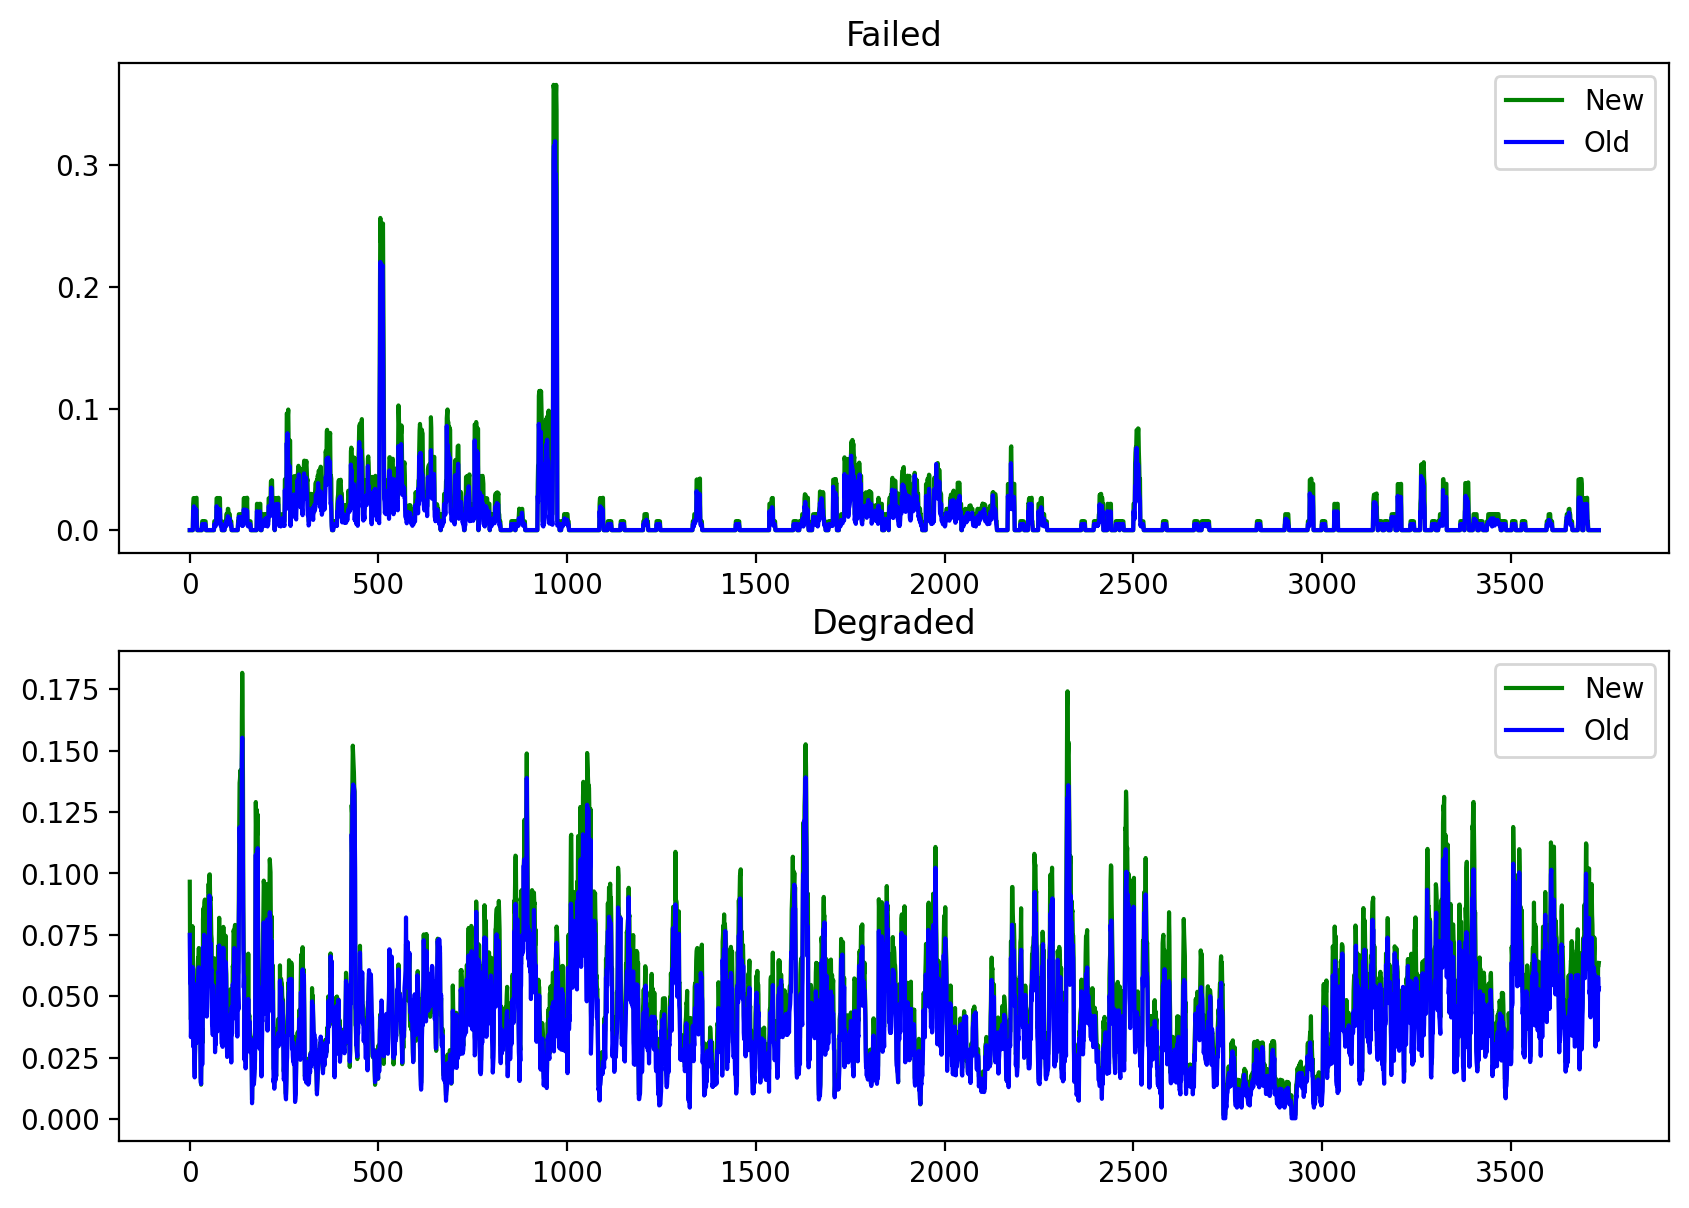

time: 324 ms (started: 2024-05-31 16:14:46 -07:00)


In [108]:
test_reconerr_mc = trainer.predict(model_mc_fd, dataloaders=DataLoader(test_ds_fd, batch_size=512), unbatch=False)
test_reconerr_mc = torch.mean(test_reconerr_mc, dim=1).detach().numpy()

test_reconerr_3 = trainer.predict(model_3_fd, dataloaders=DataLoader(test_ds_fd, batch_size=512), unbatch=False)
test_reconerr_3 = torch.mean(test_reconerr_3, dim=1).detach().numpy()

_, ax = plt.subplots(2, 1, figsize=(10, 7))
ax[0].plot(test_reconerr_mc[:, 0], color="green", label="New")
ax[0].plot(test_reconerr_3[:, 0], color="blue", label="Old")
ax[0].set_title("Failed")
ax[1].plot(test_reconerr_mc[:, 1], color="green", label="New")
ax[1].plot(test_reconerr_3[:, 1], color="blue", label="Old")
ax[1].set_title("Degraded")
ax[0].legend()
ax[1].legend()

In [114]:
model_mc_fs = VanillaMCAE(seq_len=10, n_features=2)
trainer = TimeseriesTrainer(max_epochs=70, accelerator="cpu", deterministic=True)
trainer.fit(model_mc_fs, train_dataloaders=DataLoader(train_ds_fs, batch_size=512))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:numalogic.tools.callbacks:epoch=1, train_loss=2.2762
INFO:numalogic.tools.callbacks:epoch=5, train_loss=0.7777
INFO:numalogic.tools.callbacks:epoch=10, train_loss=0.3624
INFO:numalogic.tools.callbacks:epoch=15, train_loss=0.3535
INFO:numalogic.tools.callbacks:epoch=20, train_loss=0.3528
INFO:numalogic.tools.callbacks:epoch=25, train_loss=0.3470
INFO:numalogic.tools.callbacks:epoch=30, train_loss=0.3290
INFO:numalogic.tools.callbacks:epoch=35, train_loss=0.2863
INFO:numalogic.tools.callbacks:epoch=40, train_loss=0.2470
INFO:numalogic.tools.callbacks:epoch=45, train_loss=0.1942
INFO:numalogic.tools.callbacks:epoch=50, train_loss=0.1768
INFO:numalogic.tools.callback

time: 5.37 s (started: 2024-05-31 16:16:32 -07:00)


In [115]:
model_3_fs = MultichannelAE(seq_len=10, n_channels=2)
trainer = TimeseriesTrainer(max_epochs=70, accelerator="cpu", deterministic=True)
trainer.fit(model_3_fs, train_dataloaders=DataLoader(train_ds_fs, batch_size=512))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:numalogic.tools.callbacks:epoch=1, train_loss=2.1679
INFO:numalogic.tools.callbacks:epoch=5, train_loss=0.9549
INFO:numalogic.tools.callbacks:epoch=10, train_loss=0.4223
INFO:numalogic.tools.callbacks:epoch=15, train_loss=0.3895
INFO:numalogic.tools.callbacks:epoch=20, train_loss=0.3644
INFO:numalogic.tools.callbacks:epoch=25, train_loss=0.3274
INFO:numalogic.tools.callbacks:epoch=30, train_loss=0.2581
INFO:numalogic.tools.callbacks:epoch=35, train_loss=0.2373
INFO:numalogic.tools.callbacks:epoch=40, train_loss=0.2093
INFO:numalogic.tools.callbacks:epoch=45, train_loss=0.1932
INFO:numalogic.tools.callbacks:epoch=50, train_loss=0.1831
INFO:numalogic.tools.callback

time: 6.53 s (started: 2024-05-31 16:16:41 -07:00)


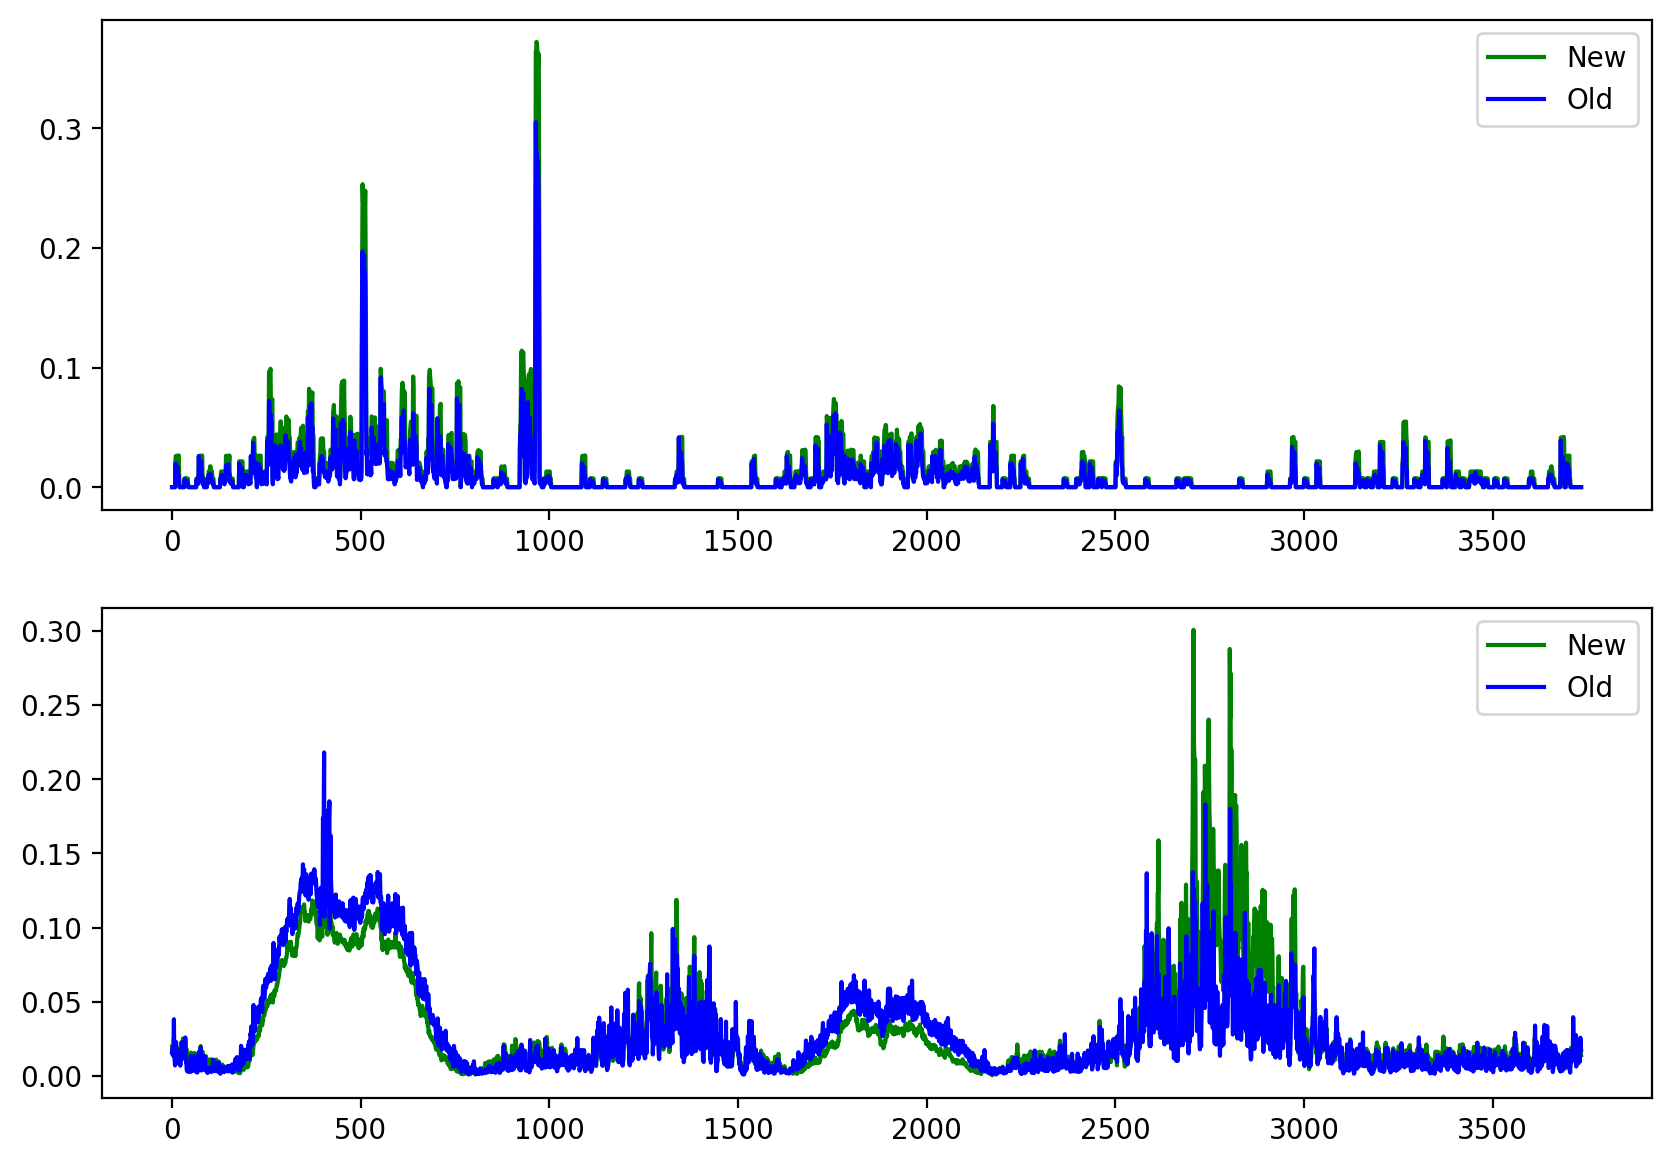

time: 285 ms (started: 2024-05-31 16:16:49 -07:00)


In [116]:
test_reconerr_mc = trainer.predict(model_mc_fs, dataloaders=DataLoader(test_ds_fs, batch_size=512), unbatch=False)
test_reconerr_mc = torch.mean(test_reconerr_mc, dim=1).detach().numpy()

test_reconerr_3 = trainer.predict(model_3_fs, dataloaders=DataLoader(test_ds_fs, batch_size=512), unbatch=False)
test_reconerr_3 = torch.mean(test_reconerr_3, dim=1).detach().numpy()

_, ax = plt.subplots(2, 1, figsize=(10, 7))
ax[0].plot(test_reconerr_mc[:, 0], color="green", label="New")
ax[0].plot(test_reconerr_3[:, 0], color="blue", label="Old")
ax[1].plot(test_reconerr_mc[:, 1], color="green", label="New")
ax[1].plot(test_reconerr_3[:, 1], color="blue", label="Old")
ax[0].legend()
ax[1].legend()